In [1]:
import torch
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold

# model architecture
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout_rate=0.2):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
        )
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        return self.relu(out)

class MLPRegressor(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=1024, num_layers=96, output_dim=2):
        super(MLPRegressor, self).__init__()
        
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )
        
        self.residual_layers = nn.ModuleList([
            ResidualBlock(hidden_dim) 
            for _ in range(num_layers - 1)
        ])
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.residual_layers:
            x = layer(x)
        return self.output_layer(x)


In [2]:
def load_models(results_dir="Results"):
    # Get the most recent run directory
    run_dirs = [d for d in os.listdir(results_dir) if d.startswith("run_")]
    latest_run = max(run_dirs)
    run_path = os.path.join(results_dir, latest_run)
    
    print(f"Loading from directory: {run_path}")
    
    # Load metrics file to get feature names
    with open(os.path.join(run_path, "metrics.json"), 'r') as f:
        metrics = json.load(f)
    
    # Load models
    models = []
    models_dir = os.path.join(run_path, "models")
    for model_file in sorted(os.listdir(models_dir)):
        model = MLPRegressor(
            input_dim=len(metrics['input_features']),
            hidden_dim=1024,
            num_layers=96,
            output_dim=len(metrics['target_variables'])
        )
        model.load_state_dict(torch.load(os.path.join(models_dir, model_file)))
        model.eval()
        models.append(model)
    
    return models, metrics

def calculate_feature_importance(model, X, y, train_idx, val_idx, n_repeats=100):
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Split the data
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    
    # Create and fit scalers on training data
    scaler = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Fit on training data
    scaler.fit(X_train)
    scaler_y.fit(y_train)
    
    # Transform validation data for importance calculation
    X_scaled = scaler.transform(X_val)
    y_scaled = scaler_y.transform(y_val)
    
    # Convert to tensor
    X_tensor = torch.FloatTensor(X_scaled).to(device)
    y_tensor = torch.FloatTensor(y_scaled).to(device)
    
    # Calculate baseline score
    with torch.no_grad():
        baseline_pred = model(X_tensor)
        baseline_score = torch.mean((baseline_pred - y_tensor) ** 2).item()
    
    # Calculate importance for each feature
    importance = np.zeros((X.shape[1], n_repeats))
    
    for feature_idx in range(X.shape[1]):
        print(f"  Processing feature {input_cols[feature_idx]} ({feature_idx + 1}/{X.shape[1]})")
        for repeat in range(n_repeats):
            # Create permuted data
            X_permuted = X_scaled.copy()
            perm_idx = np.random.permutation(len(X_permuted))
            X_permuted[:, feature_idx] = X_permuted[perm_idx, feature_idx]
            
            # Convert to tensor
            X_perm_tensor = torch.FloatTensor(X_permuted).to(device)
            
            # Calculate permuted score
            with torch.no_grad():
                perm_pred = model(X_perm_tensor)
                perm_score = torch.mean((perm_pred - y_tensor) ** 2).item()
            
            # Calculate importance
            importance[feature_idx, repeat] = perm_score - baseline_score
    
    return importance.mean(axis=1)

In [3]:
# Load data
print("Loading data...")
data = pd.read_csv('processed_data.csv')
input_cols = ['Z', 'Y_Start', 'Wall', 'Overhang', 'Power', 'd_edge', 'd_over', 'd_col', 'd_over_z']
target_cols = ['Median_meltLength', 'meanNumPixels15']

X = data[input_cols].values
y = data[target_cols].values

# Set up K-Fold cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Load models
print("Loading models...")
models, metrics = load_models()


Loading data...
Loading models...
Loading from directory: Results/run_20241115_001257


In [4]:
# Calculate importance for each fold
all_importance = []
for fold_idx, ((train_idx, val_idx), model) in enumerate(zip(kf.split(X), models)):
    print(f"Calculating importance for fold {fold_idx + 1}...")
    importance = calculate_feature_importance(model, X, y, train_idx, val_idx)
    all_importance.append(importance)
    
    # Save intermediate results after each fold
    mean_importance = np.mean(all_importance, axis=0)
    std_importance = np.std(all_importance, axis=0) if len(all_importance) > 1 else np.zeros_like(mean_importance)
    
    temp_df = pd.DataFrame({
        'Feature': input_cols,
        'Importance': mean_importance,
        'Std': std_importance
    })
    temp_df = temp_df.sort_values('Importance', ascending=False)
    print(f"\nIntermediate results after fold {fold_idx + 1}:")
    print(temp_df.to_string(index=False))


Calculating importance for fold 1...
  Processing feature Z (1/9)
  Processing feature Y_Start (2/9)
  Processing feature Wall (3/9)
  Processing feature Overhang (4/9)
  Processing feature Power (5/9)
  Processing feature d_edge (6/9)
  Processing feature d_over (7/9)
  Processing feature d_col (8/9)
  Processing feature d_over_z (9/9)

Intermediate results after fold 1:
 Feature  Importance  Std
       Z    0.024564  0.0
  d_over    0.010940  0.0
  d_edge    0.008030  0.0
 Y_Start    0.006083  0.0
d_over_z    0.002604  0.0
   d_col    0.001476  0.0
    Wall    0.001298  0.0
Overhang    0.000275  0.0
   Power    0.000000  0.0
Calculating importance for fold 2...
  Processing feature Z (1/9)
  Processing feature Y_Start (2/9)
  Processing feature Wall (3/9)
  Processing feature Overhang (4/9)
  Processing feature Power (5/9)
  Processing feature d_edge (6/9)
  Processing feature d_over (7/9)
  Processing feature d_col (8/9)
  Processing feature d_over_z (9/9)

Intermediate results afte


Final Feature Importance Rankings:
 Feature  Importance      Std
       Z    0.023328 0.003124
  d_over    0.009566 0.002713
  d_edge    0.008911 0.001642
 Y_Start    0.005739 0.000786
d_over_z    0.003452 0.000650
    Wall    0.001825 0.000551
   d_col    0.001507 0.000402
Overhang    0.000505 0.000177
   Power    0.000000 0.000000

Results saved to feature_importance_results.csv


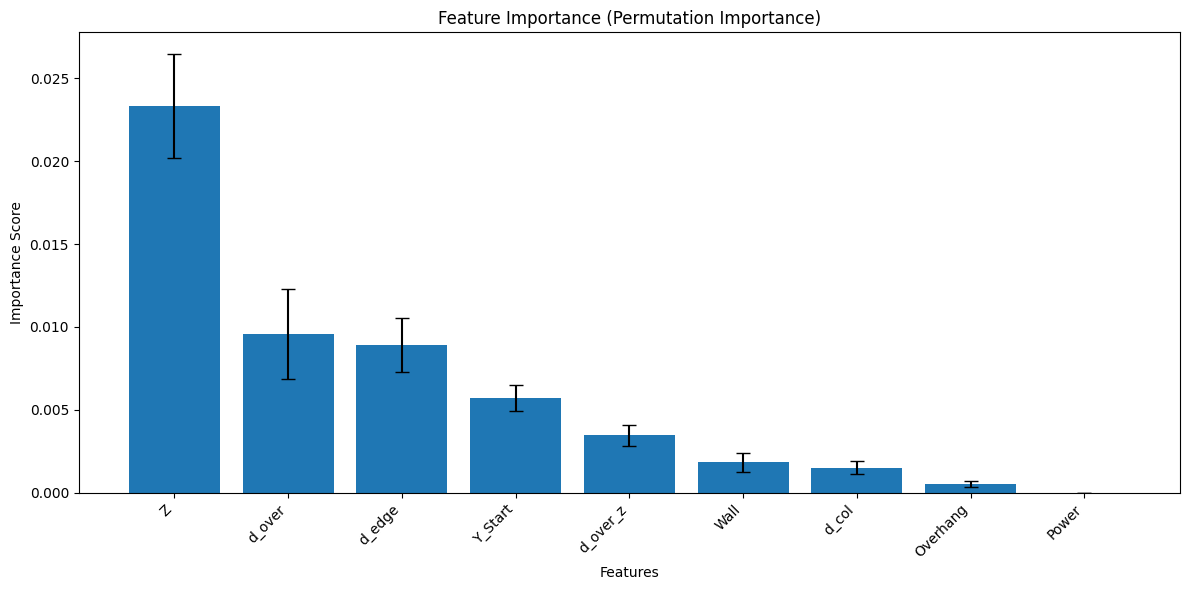

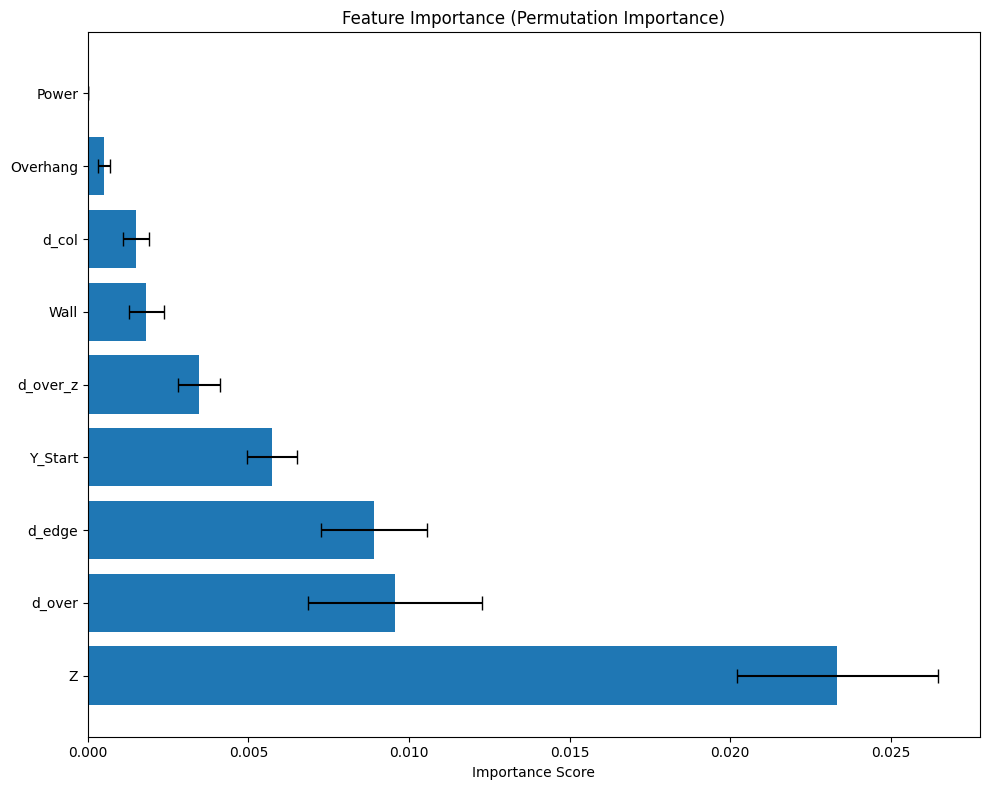

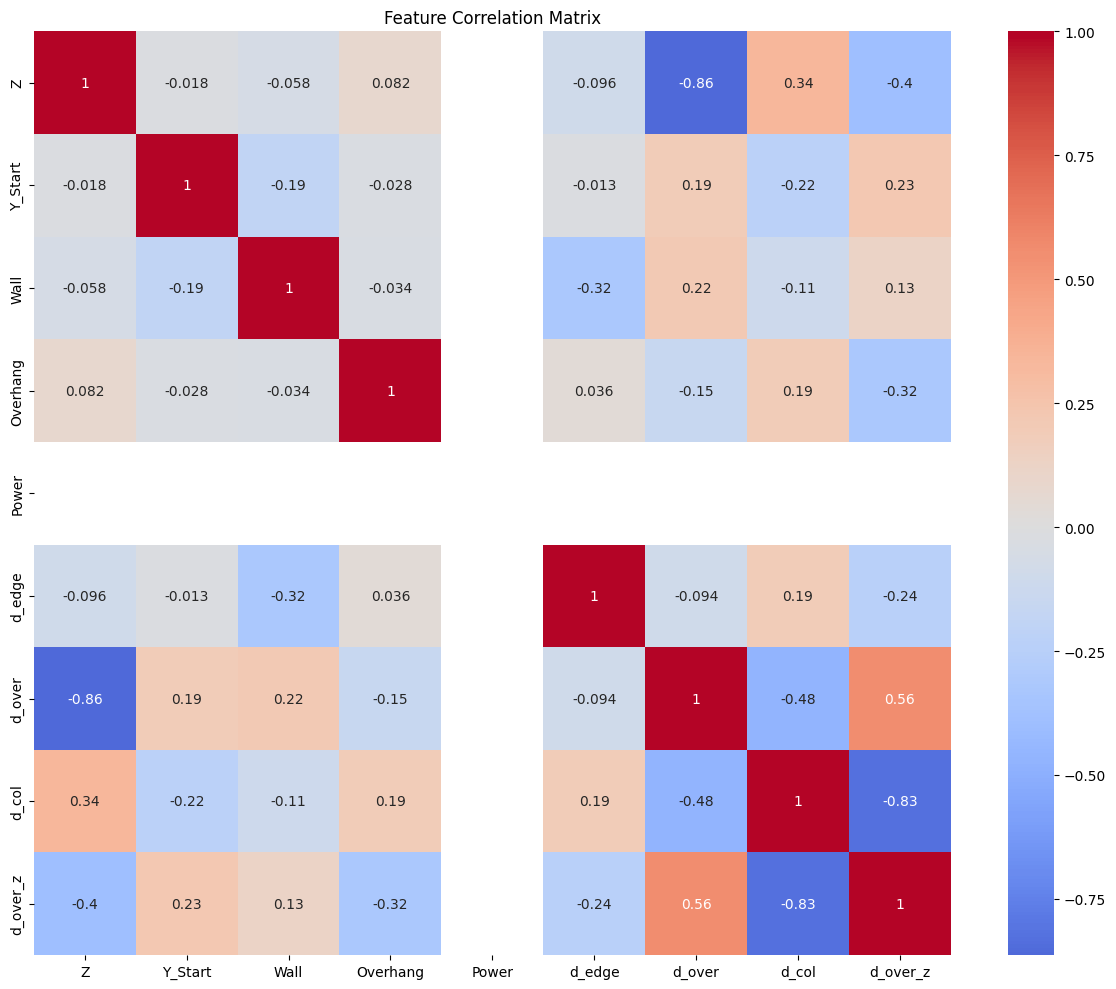


Summary of Feature Importance:
--------------------------------------------------
Most important feature: Z (score: 0.023328)
Least important feature: Power (score: 0.000000)

Feature ranking by importance:
1. Z: 0.023328 ± 0.003124
7. d_over: 0.009566 ± 0.002713
6. d_edge: 0.008911 ± 0.001642
2. Y_Start: 0.005739 ± 0.000786
9. d_over_z: 0.003452 ± 0.000650
3. Wall: 0.001825 ± 0.000551
8. d_col: 0.001507 ± 0.000402
4. Overhang: 0.000505 ± 0.000177
5. Power: 0.000000 ± 0.000000

Feature Statistics:
                 Z      Y_Start         Wall     Overhang   Power       d_edge       d_over        d_col     d_over_z
count  1812.000000  1812.000000  1812.000000  1812.000000  1812.0  1812.000000  1812.000000  1812.000000  1812.000000
mean      0.945502     1.757643     0.195916     0.022627   180.0     0.544674     2.061562     0.014708     1.461534
std       0.529797     1.019964     0.606176     0.212882     0.0     0.450107     1.447100     0.044091     0.482186
min       0.100000     0

In [5]:
# Calculate mean and std from all_importance
mean_importance = np.mean(all_importance, axis=0)
std_importance = np.std(all_importance, axis=0)

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': input_cols,
    'Importance': mean_importance,
    'Std': std_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print final numerical results
print("\nFinal Feature Importance Rankings:")
print(importance_df.to_string(index=False))

# Save results to CSV
results_file = "feature_importance_results.csv"
importance_df.to_csv(results_file, index=False)
print(f"\nResults saved to {results_file}")

# Create bar plot using plt instead of seaborn
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], 
        yerr=importance_df['Std'], capsize=5)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.title('Feature Importance (Permutation Importance)')
plt.tight_layout()
plt.show()

# Create horizontal bar plot for better readability
plt.figure(figsize=(10, 8))
y_pos = np.arange(len(importance_df['Feature']))
plt.barh(y_pos, importance_df['Importance'], 
         xerr=importance_df['Std'], capsize=5)
plt.yticks(y_pos, importance_df['Feature'])
plt.xlabel('Importance Score')
plt.title('Feature Importance (Permutation Importance)')
plt.tight_layout()
plt.show()

# Create a correlation heatmap for the features
plt.figure(figsize=(12, 10))
correlation_matrix = data[input_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary of Feature Importance:")
print("-" * 50)
print(f"Most important feature: {importance_df['Feature'].iloc[0]} (score: {importance_df['Importance'].iloc[0]:.6f})")
print(f"Least important feature: {importance_df['Feature'].iloc[-1]} (score: {importance_df['Importance'].iloc[-1]:.6f})")
print("\nFeature ranking by importance:")
for i, row in importance_df.iterrows():
    print(f"{i+1}. {row['Feature']}: {row['Importance']:.6f} ± {row['Std']:.6f}")

# Print feature statistics
print("\nFeature Statistics:")
print(data[input_cols].describe().to_string())